In [1]:
from collections import namedtuple
from collections import OrderedDict
import torch
import torch.nn.functional as F
from torch import nn
from torchvision.models import resnet50
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import VOCDetection
import torch.optim as optim
import PIL.Image as Image
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
import imageio
import math
from torchvision.transforms import Resize
import matplotlib.pyplot as plt
import numpy as np
from easydict import EasyDict as edict
import tensorflow as tf
from IPython import display
import random
from torch.autograd.function import once_differentiable
from torch.autograd import Function
import matplotlib.font_manager as fm # to create font

In [2]:
fontsize = 24
FONT = ImageFont.truetype(fm.findfont(fm.FontProperties(family='DejaVu Sans')),fontsize)

In [3]:
resnet50=resnet50(pretrained=True)

In [4]:
resnet=nn.Sequential(*list(resnet50.children()))[:-2]

In [5]:
resnet.conv1=nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)

In [6]:
resnet[4][0].downsample[0]=nn.Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
resnet[4][0].conv2=nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [7]:
#resnet[5][0].conv2=nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [8]:
#resnet[6][0].conv2=nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [9]:
#resnet[7][0].conv2=nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)

In [10]:
class Scale(nn.Module):
    def __init__(self,init_value=1.0):
        
        super(Scale,self).__init__()
        
        self.scale=nn.Parameter(torch.FloatTensor([init_value]))
    def forward(self,input):
        
        return  input*self.scale

In [11]:
class FCOSHead(nn.Module):
    
    def __init__(self,in_channel):
        
        super(FCOSHead,self).__init__()
        
        self.num_class=20
        
        cls_tower=[]
        bbox_tower=[]
        
        for i in range(4):
            
            cls_tower.append(
            nn.Conv2d(in_channel,
                     in_channel,
                     kernel_size=3,
                     stride=1,
                     padding=1))
            cls_tower.append(nn.GroupNorm(32,in_channel))
            cls_tower.append(nn.ReLU())
            
            bbox_tower.append(
            nn.Conv2d(
            in_channel,
            in_channel,
            kernel_size=3,
            stride=1,
            padding=1))
            
            bbox_tower.append(nn.GroupNorm(32,in_channel))
            bbox_tower.append(nn.ReLU())
            
        self.add_module("cls_tower",nn.Sequential(*cls_tower))
        self.add_module("bbox_tower",nn.Sequential(*bbox_tower))
        
        self.cls_logits=nn.Conv2d(in_channel,self.num_class,kernel_size=3,stride=1,padding=1)
        self.bbox_pred=nn.Conv2d(in_channel,4,kernel_size=3,stride=1,padding=1)
        
        self.centerness=nn.Conv2d(in_channel,1,kernel_size=3,stride=1,padding=1)
        
        for modules in [self.cls_tower,self.bbox_tower,self.cls_logits,self.bbox_pred,self.centerness]:
            for l in modules.modules():
                
                if isinstance(l,nn.Conv2d):
                    torch.nn.init.normal_(l.weight,std=0.01)
                    torch.nn.init.constant_(l.bias,0)
        
        self.scales=nn.ModuleList([Scale(init_value=1.0) for _ in range(5)])
        
    def forward(self,x):
            
        logits=[]
        bbox_reg=[]
        centerness=[]

        for l , feature in enumerate(x):

            cls_tower=self.cls_tower(feature)
            logits.append(self.cls_logits(cls_tower))

            centerness.append(self.centerness(cls_tower))

            bbox_reg.append(torch.exp(
            self.scales[l](self.bbox_pred(self.bbox_tower(feature)))))


        return logits,bbox_reg,centerness

In [12]:
def boxlist_iou(boxlist1,boxlist2):
    
    N=len(boxlist1)
    M=len(boxlist2)
    
    area1=(boxlist1[:,2]-boxlist1[:,0]+1)*(boxlist1[:,3]-boxlist1[:,1]+1)
    area2=(boxlist2[:,2]-boxlist2[:,0]+1)*(boxlist2[:,3]-boxlist2[:,1]+1)
    
    lt=torch.max(boxlist1[:,None,:2],boxlist2[:,:2])
    rb=torch.min(boxlist1[:,None,2:],boxlist2[:,2:])
    
    hw=(rb-lt+1).clamp(min=0)
    
    inter=hw[:,:,0]*hw[:,:,1]
    
    iou=inter/(area1[:,None]+area2-inter)
    
    return iou

In [13]:
def permute_and_flatten(layer,N,A,C,H,W):
    
    layer=layer.reshape(N,-1,C,H,W)
    layer=layer.permute(0,3,4,1,2)
    layer=layer.reshape(N,-1,C)
    
    return layer

In [14]:
def cat(tensors,dim=0):
    if len(tensors)==1:
        return tensors[0]
    return torch.cat(tensors,dim)

In [15]:
def sigmoid_focal_loss(logits,targets,gamma,alpha):
    
    num_classes=logits.shape[1]
    dtype=targets.dtype
    device=targets.device
    
    class_range=torch.arange(1,num_classes+1,dtype=dtype,device=device).unsqueeze(0)
    t=targets.unsqueeze(1)
    p=torch.sigmoid(logits)
    
    term1=(1-p)**gamma*torch.log(p)
    term2=p**gamma*torch.log(1-p)
    
    return -(t == class_range).float() * term1 * alpha - ((t != class_range) * (t >= 0)).float() * term2 * (1 - alpha)

In [16]:
torch.arange(1,10).unsqueeze(0)

tensor([[1, 2, 3, 4, 5, 6, 7, 8, 9]])

In [17]:
class SigmoidFocalLoss(nn.Module):
    
    def __init__(self,gamma,alpha):
        super(SigmoidFocalLoss,self).__init__()
        
        self.gamma=gamma
        self.alpha=alpha
        
    def forward(self,logits,targets):
        
        device=logits.device
        
        loss=sigmoid_focal_loss(logits,targets,self.gamma,self.alpha)
        
        return loss.sum()

In [18]:
class IOULoss(nn.Module):
    
    #def __init__(self):
        
    def smooth_l1_loss(self, bbox_pred, bbox_targets, sigma=1.0,dim=[1]):
        
        box_diff=bbox_pred-bbox_targets
        in_box_diff=box_diff
        abs_in_box_diff=torch.abs(in_box_diff)
        smoothL1_sign1=torch.less(abs_in_box_diff,1).detach()
        
        smoothL1_sign=torch.zeros_like(smoothL1_sign1,dtype=torch.float64)
        smoothL1_sign[smoothL1_sign1]=1
        in_loss_box1=torch.pow(in_box_diff,2)*(1/2)*smoothL1_sign+(abs_in_box_diff-0.5)*(1-smoothL1_sign)
        
        out_loss_box=in_loss_box1
        loss_box=torch.mean(torch.sum(out_loss_box,axis=dim,dtype=torch.float64))
        
        return loss_box
    
    def forward(self,pred,target,weight=None):
        
        pred_left=pred[:,0]
        pred_top=pred[:,1]
        pred_right=pred[:,2]
        pred_bottom=pred[:,3]
        
        target_left=target[:,0]
        target_top=target[:,1]
        target_right=target[:,2]
        target_bottom=target[:,3]
        
        target_area=(target_right+target_left)*(target_bottom+target_top)
        
        pred_area=(pred_right+pred_left)*(pred_bottom+pred_top)
        
        w_inter=torch.min(pred_left,target_left)+torch.min(pred_right,target_right)
        h_inter=torch.min(pred_bottom+target_bottom)+torch.min(pred_top,target_top)
        
        area_inter=w_inter*h_inter
        area_union=target_area+pred_area-area_inter
        
        losses=-torch.log((area_inter+1)/(area_union+1))
        
        loss_l1=self.smooth_l1_loss(pred,target)
        
        if weight is not None and weight.sum()>0:
            
            return (losses*weight).sum()/(weight.sum())+loss_l1
        else:
            return losses.mean()+loss_l1

In [19]:
class FCOSLossComputation(object):
    
    def __init__(self):
        
        self.cls_loss_func=SigmoidFocalLoss(2.0,0.25)
        
        self.box_reg_loss_func=IOULoss()
        
        self.centerness_loss_func=nn.BCEWithLogitsLoss()
    
    def commpute_targets_for_locations(self,locations,targets,object_size_of_interest,labels_targets):
        """
        targets,labels_targets为监督
        """
        labels=[]
        reg_targets=[]
        
        xs,ys=locations[:,0],locations[:,1]
        
        #for im_i in range(len(targets)):
            
        boxes=targets #左上右下
        labels_per_im=labels_targets
        area=(boxes[:,2]-boxes[:,0]+1)*(boxes[:,3]-boxes[:,1]+1)

        l=xs[:,None]-boxes[:,0][None]
        t=ys[:,None]-boxes[:,1][None]

        r=boxes[:,2][None]-xs[:,None]
        b=boxes[:,3][None]-ys[:,None]

        reg_targets_per_im=torch.stack([l,t,r,b],dim=2)

        is_in_boxes=reg_targets_per_im.min(dim=2)[0]>0

        max_reg_targets_per_im=reg_targets_per_im.max(dim=2)[0]

        is_cared_in_the_level=\
        (max_reg_targets_per_im>=object_size_of_interest[:,[0]])&\
        (max_reg_targets_per_im<=object_size_of_interest[:,[1]])

        locations_to_gt_area=area[None].repeat(len(locations),1)
        locations_to_gt_area[is_in_boxes==0]=99999
        locations_to_gt_area[is_cared_in_the_level==0]=99999


        locations_to_min_area,locations_to_gt_inds=locations_to_gt_area.min(dim=1)

        reg_targets_per_im=reg_targets_per_im[range(len(locations)),locations_to_gt_inds]
        labels_per_im=labels_per_im[locations_to_gt_inds]
        labels_per_im[locations_to_min_area==99999]=0

        labels.append(labels_per_im)
        reg_targets.append(reg_targets_per_im)
                
        return labels,reg_targets
                
        
    def prepare_targets(self,points,targets,labels_targets):
        
        object_size_of_interest=[
            [-1,64],
            [64,128],
            [128,256],
            [256,512],
            [512,99999]
        ]
        
        
        expanded_object_size_of_interest=[]
        
        for l,points_per_level in enumerate(points):
            
            object_size_of_interest_per_level=points_per_level.new_tensor(object_size_of_interest[l])
            expanded_object_size_of_interest.append(object_size_of_interest_per_level[None].expand(len(points_per_level),-1))
            
        expanded_object_size_of_interest=torch.cat(expanded_object_size_of_interest,dim=0)
        
        num_points_per_level=[len(points_per_level) for points_per_level in points]
        
        point_all_level=torch.cat(points,dim=0)
        
        labels,reg_targets=self.commpute_targets_for_locations(point_all_level,targets,expanded_object_size_of_interest,labels_targets)
        
        
        for i in range(len(labels)):
            
            labels[i]=torch.split(labels[i],num_points_per_level,dim=0)
            reg_targets[i]=torch.split(reg_targets[i],num_points_per_level,dim=0)
            
        label_level_first=[]
        reg_target_level_first=[]
        
        for level in range(len(points)):
            
            label_level_first.append(
            torch.cat([labels_per_im[level] for labels_per_im in labels],dim=0)
            )
            
            reg_target_level_first.append(
            torch.cat([reg_targets_per_im[level] for reg_targets_per_im in reg_targets],dim=0)
            )
            
        return label_level_first,reg_target_level_first
    
    def compute_centerness_targets(self,reg_target):
        
        left_right=reg_target[:,[0,2]]
        top_bottom=reg_target[:,[1,3]]
        
        centerness=(left_right.min(dim=-1)[0]/left_right.max(dim=-1)[0])*\
        (top_bottom.min(dim=-1)[0]/top_bottom.max(dim=-1)[0])
        
        
        return torch.sqrt(centerness)
    
    def __call__(self,locations,box_cls,box_regression,centerness,targets,labels_targets):
        
        N=box_cls[0].size()[0]
        
        num_class=box_cls[0].size()[1]
        labels,reg_targets=self.prepare_targets(locations,targets,labels_targets)
        
        box_cls_flatten=[]
        box_regression_flatten=[]
        centerness_flatten=[]
        labels_flatten=[]
        reg_targets_flatten=[]
        
        
        for l in range(len(labels)):
            
            box_cls_flatten.append(box_cls[l].permute(0,2,3,1).reshape(-1,num_class))
            
            box_regression_flatten.append(box_regression[l].permute(0,2,3,1).reshape(-1,4))
            
            labels_flatten.append(labels[l].reshape(-1))
            
            reg_targets_flatten.append(reg_targets[l].reshape(-1,4))
            
            centerness_flatten.append(centerness[l].reshape(-1))
            
        box_cls_flatten=torch.cat(box_cls_flatten,dim=0)
        box_regression_flatten=torch.cat(box_regression_flatten,dim=0)
        labels_flatten=torch.cat(labels_flatten,dim=0)
        reg_targets_flatten=torch.cat(reg_targets_flatten,dim=0)
        centerness_flatten=torch.cat(centerness_flatten,dim=0)
        pos_inds=torch.nonzero(labels_flatten>0).squeeze(1)

        cls_loss=self.cls_loss_func(
        box_cls_flatten,
        labels_flatten.int())/(pos_inds.numel()+N)
        
        
        box_regression_flatten=box_regression_flatten[pos_inds]
        centerness_flatten=centerness_flatten[pos_inds]
        reg_targets_flatten=reg_targets_flatten[pos_inds]
        
        if pos_inds.numel()>0:
            
            centerness_targets=self.compute_centerness_targets(reg_targets_flatten)
            
            reg_loss=self.box_reg_loss_func(
            box_regression_flatten,
            reg_targets_flatten,
            centerness_targets)
            
            centerness_loss=self.centerness_loss_func(centerness_flatten,centerness_targets)
        else:
            
            reg_loss=box_regression_flatten.sum()
            centerness_loss=centerness_flatten.sum()
            
        return cls_loss,reg_loss,centerness_loss
        
        
        

In [20]:
def make_fcos_loss_evalutor():
    loss_evaluator=FCOSLossComputation()
    return loss_evaluator

In [21]:
def clip_to_image(boxes,size):
    
    boxes[:,0].clamp(min=0,max=size[1]-1)
    boxes[:,1].clamp(min=0,max=size[0]-1)
    boxes[:,2].clamp(min=0,max=size[1]-1)
    boxes[:,3].clamp(min=0,max=size[0]-1)
    
    keep=(boxes[:,2]>boxes[:,0])&(boxes[:,3]>boxes[:,1])
    
    boxes=boxes[keep]
    
    return boxes,keep

In [22]:
def remove_small_box(boxes,minsize):
    
    ws=boxes[:,2]-boxes[:,0]
    hs=boxes[:,3]-boxes[:,1]
    
    keep=(ws>=minsize)&(hs>=minsize)
    
    boxes=boxes[keep]
    
    return boxes,keep

In [23]:
class FCOSPostProcessor(nn.Module):
    def __init__(self,
                pre_nms_thresh,
                pre_nms_top_n,
                nms_thresh,
                fpn_post_nmstop_n,
                min_size,
                num_class):
        
        super(FCOSPostProcessor,self).__init__()
        
        self.pre_nms_thresh=pre_nms_thresh
        self.pre_nms_top_n=pre_nms_top_n
        
        self.nms_thresh=nms_thresh
        self.fpn_post_nmstop_n=fpn_post_nmstop_n
        self.min_size=min_size
        self.num_class=num_class
        
    def forward_for_single_feature_map(
    self,locations,box_cls,box_regression,centerness,image_sizes):
        
        N,C,H,W=box_cls.shape
        
        box_cls=box_cls.reshape(N,C,H,W).permute(0,2,3,1)
        box_cls=box_cls.reshape(N,-1,C).sigmoid()
        
        box_regression=box_regression.reshape(N,4,H,W).permute(0,2,3,1)
        box_regression=box_regression.reshape(N,-1,4)
        
        centerness=centerness.reshape(N,1,H,W).permute(0,2,3,1)
        centerness=centerness.reshape(N,-1).sigmoid()
        
        candidate_inds=box_cls>self.pre_nms_thresh
        
        pre_nms_top_n=candidate_inds.reshape(N,-1).sum(1)
        
        pre_nms_top_n=pre_nms_top_n.clamp(max=self.pre_nms_top_n)
        
        box_cls=box_cls*centerness[:,:,None]
        
        results=[]
        
        for i in range(N):
            per_box_cls=box_cls[i]
            per_candidate_inds=candidate_inds[i]
            per_box_cls=per_box_cls[per_candidate_inds]
            
            per_candidate_nonzeros=per_candidate_inds.nonzero()
            per_box_loc=per_candidate_nonzeros[:,0]
            per_class=per_candidate_nonzeros[:,1]+1
            
            per_box_regression=box_regression[i]
            per_box_regression=per_box_regression[per_box_loc]
            per_locations=locations[per_box_loc]
            
            per_pre_nms_top_n=pre_nms_top_n[i]
            
            if per_candidate_inds.sum().item()>per_pre_nms_top_n:
                
                per_box_cls,top_k_indices=per_box_cls.topk(per_pre_nms_top_n,sorted=False)
                
                per_class=per_class[top_k_indices]
                per_box_regression=per_box_regression[top_k_indices]
                per_locations=per_locations[top_k_indices]
                
            detections=torch.stack(
            [
                per_locations[:,0]-per_box_regression[:,0],
                per_locations[:,1]-per_box_regression[:,1],
                per_locations[:,0]+per_box_regression[:,2],
                per_locations[:,1]+per_box_regression[:,3]
            ],dim=1)
            
            h,w=image_sizes[i]
            size=[h,w]
            detections,keeps=clip_to_image(detections,size)
            labels=per_class[keeps]
            scores=per_box_cls[keeps]
            
            detections,keeps=remove_small_box(detections,self.min_size)
            labels=labels[keeps]
            scores=scores[keeps]
            
            out={
                "detections":detections,
                "labels":labels,
                "scores":scores
            }
            
            results.append(out)
            

        return results[0]
    def nms(self,proposals,scores,Threshold=0.7):
        


        x1=proposals[:,0]
        y1=proposals[:,1]
        x2=proposals[:,2]
        y2=proposals[:,3]

        areas=(y2-y1+1)*(x2-x1+1)
        scores=torch.squeeze(scores)
        orders=(-1*scores).argsort()
        keep=[]
        print(orders)
        if len(orders)==0:
            return 0
        else:
            while orders.size()[0]>0:

                i=orders[0]

                keep.append(i)

                xx1=torch.maximum(x1[i],x1[orders[1:]])
                yy1=torch.maximum(y1[i],y1[orders[1:]])
                xx2=torch.minimum(x2[i],x2[orders[1:]])
                yy2=torch.minimum(y2[i],y2[orders[1:]])

                ws=torch.maximum(xx2-xx1+1,torch.tensor(0))
                hs=torch.maximum(yy2-yy1+1,torch.tensor(0))

                inter=ws*hs
                iou=inter/(areas[i]+areas[orders[1:]]-inter)

                index=torch.where(iou<Threshold)[0]

                orders=orders[index+1]

            keep=torch.tensor(keep)

            return keep

    def select_over_all_levels(self,boxes,labels,scores):
        results_boxes=[]
        results_labels=[]
        results_scores=[]
        for j in range(1,self.num_class):
            
            inds=(labels==j).nonzero().reshape(-1)
            if len(inds)==0:
                continue
            labels_j=labels[inds]
            scores_j=scores[inds]
            boxes_j=boxes[inds,:].reshape(-1,4)
            
            #keep=self.nms(boxes_j,scores_j,Threshold=self.nms_thresh)
            
            #boxes_j=boxes_j[keep]
            #labels_j=labels_j[keep]
            #scores_j=scores_j[keep]
            results_boxes.append(boxes_j)
            results_labels.append(labels_j)
            results_scores.append(scores_j)
        
        boxes=torch.vstack(results_boxes)
        labels=torch.hstack(results_labels)
        scores=torch.hstack(results_scores)
        
        
        return boxes,labels,scores
   
    def forward(self,locations,box_cls,box_regression,centerness,image_sizes):
        
        sampled_boxes=[]
        for _,(l,o,b,c)in enumerate(zip(locations,box_cls,box_regression,centerness)):
            
            sampled_boxes.append(self.forward_for_single_feature_map(l,o,b,c,image_sizes))
            
        boxes=torch.vstack((sampled_boxes[0]["detections"],sampled_boxes[1]["detections"],sampled_boxes[2]["detections"]
                           ,sampled_boxes[3]["detections"],sampled_boxes[4]["detections"]))
        labels=torch.hstack((sampled_boxes[0]["labels"],sampled_boxes[1]["labels"],sampled_boxes[2]["labels"]
                           ,sampled_boxes[3]["labels"],sampled_boxes[4]["labels"]))
        
        scores=torch.hstack((sampled_boxes[0]["scores"],sampled_boxes[1]["scores"],sampled_boxes[2]["scores"]
                           ,sampled_boxes[3]["scores"],sampled_boxes[4]["scores"]))
        
        
        boxes,labels,scores=self.select_over_all_levels(boxes,labels,scores)
        
        number_of_detections=len(boxes)
        
        if number_of_detections >self.fpn_post_nmstop_n>0:
            
            thresh,_=torch.kthvalue(scores,number_of_detections-self.fpn_post_nmstop_n+1)
            
            keep=scores>=thresh
            
            keep=torch.nonzero(keep).squeeze(1)
            
            boxes=boxes[keep,:]
            labels=labels[keep]
            
            scores=scores[keep]
        return boxes,labels,scores
            
            
            
            

In [24]:
def make_fcos_postprocessor():
    
    pre_nms_tresh=0.05
    pre_nms_top_n=1000
    nms_thresh=0.6
    fpn_post_nms_top_n=100
    
    box_selector=FCOSPostProcessor(pre_nms_thresh=pre_nms_tresh,
                                  pre_nms_top_n=pre_nms_top_n,
                                  nms_thresh=nms_thresh,
                                  fpn_post_nmstop_n=fpn_post_nms_top_n,
                                  min_size=0,
                                  num_class=21,
                                  )
    
    return box_selector

In [25]:
class make_layers(nn.Module):
    def __init__(self):
        super(make_layers,self).__init__()
        
    
    def get_group_gn(self,dim,dim_per_gp,num_group):
        
        if dim_per_gp>0:
            
            group_gn=dim//dim_per_gp
        else:
            
            group_gn=num_group
        return group_gn
    
    def group_norm(self,out_channel,affine=True,divisor=1):
        
        out_channel=out_channel//divisor
        
        dim_per_gp=-1//divisor
        
        num_group=32//divisor
        
        eps=1e-5
        
        return nn.GroupNorm(self.get_group_gn(out_channel,dim_per_gp,num_group),
                           out_channel,
                           eps,
                           affine)
    
    def conv_with_kaiming_uniform(self,in_channel,out_channel,kernel_size,use_gn=False,use_relu=False,stride=1,dilation=1):
        
        conv=nn.Conv2d(in_channel,out_channel,kernel_size,stride,padding=dilation*(kernel_size-1)//2,bias=False if use_gn else True)

        nn.init.kaiming_normal_(conv.weight,a=1)

        if not use_gn:

            nn.init.constant_(conv.bias,0)

        module=[conv,]

        if use_gn:

            module.append(self.group_norm(out_channel))
        if use_relu:

            module.append(nn.ReLU(inplace=True))

        if len(module)>1:
            return nn.Sequential(*module)

        return conv
    
                

In [26]:
class lastlevelp6p7(nn.Module):
    def __init__(self,in_channels,out_channels):
        
        super(lastlevelp6p7,self).__init__()
        
        self.p6=nn.Conv2d(in_channels,out_channels,3,2,1)
        self.p7=nn.Conv2d(out_channels,out_channels,3,2,1)
        
        for module in [self.p6,self.p7]:
            
            nn.init.kaiming_normal_(module.weight,a=1)
            nn.init.constant_(module.bias,0)
            
        self.use_p5=in_channels==out_channels
        
    def forward(self,p5):
        x=p5
        p6=self.p6(x)
        p7=self.p7(F.relu(p6))
        
        return [p6,p7]

In [27]:
class FPN(nn.Module):
    
    def __init__(self,in_channels_list,out_channels,top_blocks=None):
        super(FPN,self).__init__()
        
        self.inner_blocks=[]
        self.layer_blocks=[]
        
        for idx,in_channels in enumerate(in_channels_list,1):
            
            inner_block="fpn_inner{}".format(idx)
            layer_block="fpn_layer{}".format(idx)
            if in_channels==0:
                continue
            inner_block_module=make_layers().conv_with_kaiming_uniform(in_channels,out_channels,1)
            layer_block_module=make_layers().conv_with_kaiming_uniform(out_channels,out_channels,3,1)
            
            self.add_module(inner_block,inner_block_module)
            
            self.add_module(layer_block,layer_block_module)
            
            self.inner_blocks.append(inner_block)
            self.layer_blocks.append(layer_block)
            
        self.top_blocks=top_blocks
    def forward(self,x):
        x=x[1:]
        last_inner=getattr(self,self.inner_blocks[-1])(x[-1])
        results=[]
        
        results.append(getattr(self,self.layer_blocks[-1])(last_inner))
        
        for feature,inner_block,layer_block in zip(x[:-1][::-1],self.inner_blocks[:-1][::-1],self.layer_blocks[:-1][::-1]):
            inner_lateral=getattr(self,inner_block)(feature)
            n,c,h,w=inner_lateral.shape
            inner_top_down=F.interpolate(last_inner,size=(h,w),mode="nearest")

            last_inner=inner_top_down+inner_lateral
            
            results.insert(0,getattr(self,layer_block)(last_inner))
            
        last_result=self.top_blocks(results[-1])
        
        results.extend(last_result)
        
        return tuple(results) 

In [28]:
class backbone(nn.Module):
    def __init__(self,resnet):
        super(backbone,self).__init__()
        
        self.lastlevelp6p7=lastlevelp6p7(256*4,256*4)
        self.FPN=FPN(
        in_channels_list=[
            0,
            256*2,
            256*4,
            256*8
        ],
        out_channels=256*4,
        top_blocks=self.lastlevelp6p7)
        self.basestem=resnet[0:4]
        self.layer1=resnet[4]
        self.layer2=resnet[5]
        self.layer3=resnet[6]
        self.layer4=resnet[7]
        
        
    def get_C3_to_C5(self,image):
        
        x=image.type(torch.cuda.FloatTensor)
        
        x=self.basestem(x)
        
        C2=self.layer1(x)
        
        C3=self.layer2(C2)
        
        C4=self.layer3(C3)
        
        C5=self.layer4(C4)
        
        
        return [C2,C3,C4,C5]
    def forward(self,image):
        
        body=self.get_C3_to_C5(image)
        
        in_channels_stage2=256
        out_channels=256*4
        
        in_channel_p6p7=256*8
        
        fpn=self.FPN(body)
        
        return fpn

In [29]:
class FCOSModule(nn.Module):
    
    def __init__(self,in_channel):
        super(FCOSModule,self).__init__()
        self.fpn_stride=[8, 16, 32, 64, 128]
        
        self.head=FCOSHead(in_channel)
        self.loss_evaluator=make_fcos_loss_evalutor()
        self.box_selector_test=make_fcos_postprocessor()
        
        
        
    
    def compute_locations_per_level(self,h,w,stride,device):
        
        shifts_x=torch.arange(0,w*stride,step=stride,dtype=torch.float32,device=device)
        shifts_y=torch.arange(0,h*stride,step=stride,dtype=torch.float32,device=device)
        
        shifts_y,shifts_x=torch.meshgrid(shifts_y,shifts_x)
        shifts_x=shifts_x.reshape(-1)
        shifts_y=shifts_y.reshape(-1)
        
        locations=torch.stack((shifts_x,shifts_y),dim=1)+stride//2
        
        return locations
        
    def compute_locations(self,features):
        
        locations=[]
        for level,feature in enumerate(features):
          
            c,n,h,w=feature.size()
            locations_per_level=self.compute_locations_per_level(h,w,self.fpn_stride[level],feature.device)
            
            locations.append(locations_per_level)
            
        return locations
    def _forward_train(self,locations,box_cls,box_regression,centerness,targets,labels_targets):

        loss_box_cls,loss_box_reg,loss_centerness=self.loss_evaluator(
        locations,box_cls,box_regression,centerness,targets,labels_targets)
        
        losses={
            "loss_cls":loss_box_cls,
            "loss_reg":loss_box_reg,
            "loss_centerness":loss_centerness
        }
        
        return losses
    
    def _forward_test(self,locations,box_cls,box_regression,centerness,image_sizes):
        
        boxes,labels,scores=self.box_selector_test(
        locations,box_cls,box_regression,centerness,image_sizes)
        
        
        return [boxes,labels,scores]
        
        
            
            
    def forward(self,features,targets=None,labels_targets=None,is_training=False,image_sizes=None):
        
        box_cls,box_regression,centerness=self.head(features)
        
        locations=self.compute_locations(features)
        if is_training:
            
            return self._forward_train(locations,box_cls,box_regression,centerness,targets,labels_targets)
        else:
            
            return self._forward_test(locations,box_cls,box_regression,centerness,image_sizes)

In [30]:
class FCOS(nn.Module):
    
    def __init__(self):
        super(FCOS,self).__init__()
        self.backbone=backbone(resnet)
        self.FCOSModule=FCOSModule(1024)
        
    def forward(self,image,tragets=None,labels_targets=None,is_training=False):
        
        c,n,h,w=image.shape
        image_sizes=[[h,w]]
        fpn=self.backbone(image)
        out=self.FCOSModule(fpn,tragets,labels_targets,is_training,image_sizes=image_sizes)
        
        return out
        
        

In [31]:
net=FCOS().to('cuda')
optimizer = optim.Adam(net.parameters(), lr=0.00001) #设置优化器和学习率

In [32]:
def draw_one(images,xmin,ymin,xmax,ymax,display_str,font,color='red',thickness=1):
        
    draw = ImageDraw.Draw(images)
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    draw.line([(left, top), (left, bottom), (right, bottom),
             (right, top), (left, top)], width=thickness, fill=color)
    text_bottom = top
    text_width, text_height = font.getsize(display_str)
    #print(text_width,text_height)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle(
      [(left, text_bottom - text_height - 2 * margin), (left + text_width,
                                                        text_bottom)],
      fill=color)
    draw.text(
      (left + margin, text_bottom - text_height - margin),
      display_str,
      fill='black',
      font=font)

    return images
def draw_it(image,labels,box):
    
    num_box=box.size()[0]
    image=torch.squeeze(image)
    image=image.permute(1,2,0)
    image=image.to('cpu').numpy()
    image=np.round((image*0.5+0.5)*255)
    image=image.astype(np.uint8)
    image=Image.fromarray(image)
    for i in range(num_box):
        the_class=labels[i]
        xmin,ymin,xmax,ymax=box[i,0],box[i,1],box[i,2],box[i,3]
        image=draw_one(image,xmin,ymin,xmax,ymax,'%s'%(the_class),FONT)
    image=torch.tensor(np.array(image))  
    return image   

In [33]:
train_tramforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])

In [34]:
train=VOCDetection('C:/数据/目标检测voc2007/',year='2007',image_set='train',download=False,transform=train_tramforms)

In [35]:
def get_coo_image(train):
    data_set=[]
    images=[]
    for i in range(len(train)):
      #  i=0
        #label=0
        #if i==707:
         #   pass
        if i in [707,1660]:
            continue
        data=[]
        for j in range(len(train[i][1]['annotation']['object'])):
        
            xmin=int(train[i][1]['annotation']['object'][j]['bndbox']['xmin'])
            ymin=int(train[i][1]['annotation']['object'][j]['bndbox']['ymin'])
            xmax=int(train[i][1]['annotation']['object'][j]['bndbox']['xmax'])
            ymax=int(train[i][1]['annotation']['object'][j]['bndbox']['ymax'])
            name=train[i][1]['annotation']['object'][j]['name']
           # if (xmax-xmin)<150 or (ymax-ymin)<150:
           #     label=1
           #     break
            data.append([xmin,ymin,xmax,ymax,name])
            
       
        image=train[i][0]
       # if label!=1:
        data_set.append(data)
        images.append(image)
      #  if i==0:
       #     break

        
        
    return data_set,images

In [36]:
datasets1,images1=get_coo_image(train)
name=['cow', 'aeroplane', 'bottle', 'bird', 'motorbike', 'person', 'tvmonitor', 'sofa', 'car', 'boat', 'cat', 'horse', 'train', 'bus', 'bicycle', 'chair', 'dog', 'pottedplant', 'sheep', 'diningtable','nan']

In [37]:
dataset=datasets1

In [38]:
for i in range(len(dataset)):
    for j in range(len(dataset[i])):
        dataset[i][j][-1]=name.index(dataset[i][j][-1])

In [39]:
def get_best(name,scores,proposals):
    Threshold=0.4
    x1=proposals[:,0]
    y1=proposals[:,1]
    x2=proposals[:,2]
    y2=proposals[:,3]

    areas=(y2-y1+1)*(x2-x1+1)
    scores=torch.squeeze(scores)
    orders=(-1*scores).argsort()
    keep=[]
    while orders.size()[0]>0:

        i=orders[0]

        keep.append(i)

        xx1=torch.maximum(x1[i],x1[orders[1:]])
        yy1=torch.maximum(y1[i],y1[orders[1:]])
        xx2=torch.minimum(x2[i],x2[orders[1:]])
        yy2=torch.minimum(y2[i],y2[orders[1:]])

        ws=torch.maximum(xx2-xx1+1,torch.tensor(0))
        hs=torch.maximum(yy2-yy1+1,torch.tensor(0))

        inter=ws*hs
        iou=inter/(areas[i]+areas[orders[1:]]-inter)

        index=torch.where(iou<Threshold)[0]

        orders=orders[index+1]
    
    keep=torch.tensor(keep)
    proposals=proposals[keep,:]
    name=name[keep]
    return proposals,name

In [40]:
def train_rcnn(epoches,images,datasets):
    
    length=len(datasets)
    net.train()
    for i_2 in range(epoches):
        num=0
        for j in range(len(images)-100):
            
            print("epocges:%d    "%(i_2),"num:%d    "%(j),end="\r")

            optimizer.zero_grad()
            image=images[j].to('cuda')
            image=image
            image=image.unsqueeze(0)
            n1,c1,h1,w1=image.size()
            gt_box=torch.tensor(datasets[j],dtype=torch.float64,device='cuda')
            targets=gt_box[:,:-1]
            labels_targets=gt_box[:,-1]
            #image = image.to(device)
           # gt_box = gt_box.to(device)
            out=net(image,targets,labels_targets,is_training=True)
            loss=out["loss_cls"]+out["loss_reg"]+out["loss_centerness"]

            loss.backward()
            optimizer.step()
            if j%200==0:
                """
                测试一张图片
                """
                test_num=random.randint(2400,2498)
                #test_num=j
                image=images[test_num].to('cuda')
                image=image.unsqueeze(0)
                #gt_box=torch.tensor(datasets[test_num],dtype=torch.float64,device='cuda')
                out=net(image)
                boxes,labels,scores=out
                boxes=boxes.to('cpu').detach()
                labels=labels.to('cpu').detach()
                scores=scores.to('cpu').detach()
                #print(boxes)
                index2=torch.where(scores>0.05)[0]
                boxes=boxes[index2,:]
                labels=labels[index2]
                scores=scores[index2]
                if len(index2)<=1:
                    pass
                else:
                    display.clear_output(wait=True)

                    list_name=[]
                    for i in range(len(labels)):
                        list_name.append(labels[i])
                    list_name=torch.tensor(list_name)
                    boxes,names=get_best(list_name,scores,boxes)

                    list_name=[]
                    
                    for i in range(len(names)):
                        list_name.append(name[names[i]])
                    boxes=torch.round(boxes).type(torch.int)
                    image=draw_it(image,list_name,boxes)
                    image=torch.squeeze(image.to('cpu'))
                    plt.imshow(image)
                    plt.show()

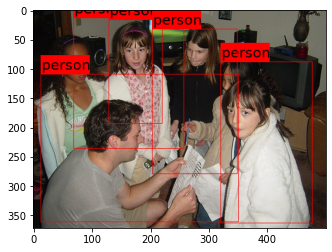

In [ ]:
train_rcnn(800,images1,dataset)